In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import sqlite3 as db
import datetime as dt
import pandas as pd

projectDir = os.path.dirname(os.path.abspath(os.path.curdir))
dbFile = os.path.join(projectDir, 'db', '2019_nCov_data.db')

conn = db.connect(dbFile)
cu = conn.cursor()

## 介绍

接下来的数据分析基于知乎上[Snowino](https://www.zhihu.com/question/368541456/answer/991544464?utm_source=wechat_session&utm_medium=social&utm_oi=40289565671424)的回答。

在此对[Snowino](https://www.zhihu.com/question/368541456/answer/991544464?utm_source=wechat_session&utm_medium=social&utm_oi=40289565671424)的精彩分析表示感谢。

## 前言

需要回答的几个关键问题：

- 武汉／湖北／全国各大小城市**封城**以后，疫情**传播速度是否得到控制**？
- 湖北现在医疗系统**是否超负荷了**？
- 疫情接下来几天会如何发展？
- 如果我得了这个病，我有多大概率会死？

回答这些问题前，我们需要谈论数据的可信度。

Text(0.5, 0.6, '全国实时表观死亡比例 = 累计死亡数/累计确诊数')

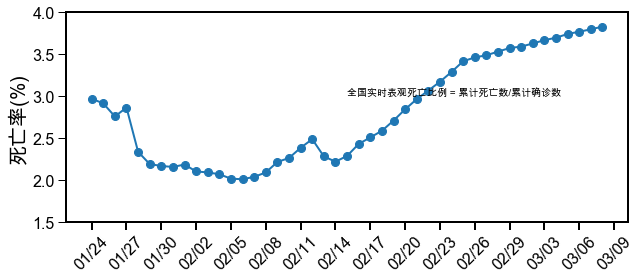

In [2]:
import matplotlib.dates as mdates

plt.rcParams['font.family'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# get overall deadth count
df = pd.read_sql_query("""select time, deadCount, confirmedCount from Overall""", conn)
df['date'] = pd.to_datetime(df['time']/1000, unit='s')
df = df.set_index('date')
dailyMean = df.resample('D').mean()

plt.figure(figsize=[9,4])
plt.plot(dailyMean.index, dailyMean['deadCount']/dailyMean['confirmedCount']*100, marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

# plt.xlabel('日期')
plt.ylabel(u'死亡率(%)')

plt.ylim([1.5, 4.0])

plt.text(0.5, 0.6, '全国实时表观死亡比例 = 累计死亡数/累计确诊数', transform=plt.gca().transAxes, )

网上有质疑国家统计数据的言论如下：

> 实时表观累计死亡比例一直都是2.1%，因此数据是人造的！

由上图可知，基于数据计算的死亡率并不是一个固定值，因此如上说法并不准确。我们应该相信国家统计数据的**权威性**。

**武汉/湖北/全国各大小城市封城以后，疫情传播速度是否得到控制？**



(0, 1400)

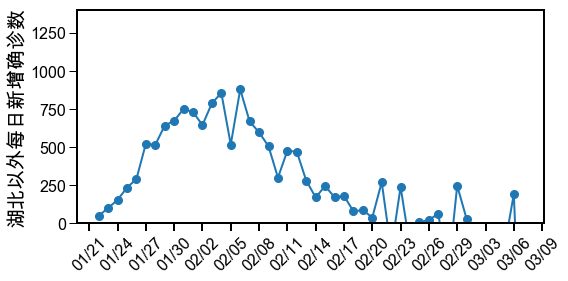

In [3]:
# get overall deadth count
OverallDf = pd.read_sql_query("""select updateTime, deadCount, confirmedCount, provinceName from Region_Data where provinceName!='湖北省' and country='中国' and provinceName!='待明确地区';""", conn)
OverallDf['date'] = pd.to_datetime(OverallDf['updateTime'].apply(int)/1000, unit='s')
OverallDf = OverallDf.set_index('date')
OverallDf = OverallDf.groupby('provinceName')
dailyMeanOverall = OverallDf.resample('D').mean().round().groupby('date')
totalConfirmedCount = dailyMeanOverall['confirmedCount'].agg(np.sum)[:-1]

plt.figure(figsize=[8, 4])
plt.plot(totalConfirmedCount.index[1:], np.diff(totalConfirmedCount), marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

# plt.xlabel('日期')
plt.ylabel('湖北以外每日新增确诊数')

plt.ylim([0, 1400])

(0, 4000)

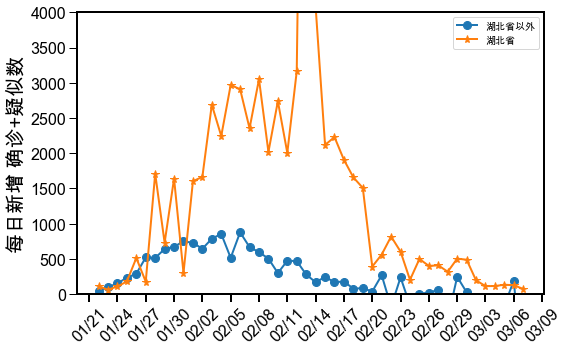

In [4]:
# get data
OverallDf = pd.read_sql_query("""select updateTime, confirmedCount as totalCount, provinceName from Region_Data where provinceName!='湖北省' and country='中国' and provinceName != '待明确地区'""", conn)
OverallDf['date'] = pd.to_datetime(OverallDf['updateTime'].apply(int)/1000, unit='s')
OverallDf = OverallDf.set_index('date')
OverallDf = OverallDf.groupby('provinceName')
dailyMeanOverall = OverallDf.resample('D').mean().round().groupby('date')
totalCount = (dailyMeanOverall['totalCount']).agg(np.sum)[:-1]

HubeiDf = pd.read_sql_query("""select updateTime, confirmedCount as totalCount, provinceName from Region_Data where provinceName='湖北省'""", conn)
HubeiDf['date'] = pd.to_datetime(HubeiDf['updateTime'].apply(int)/1000, unit='s')
HubeiDf = HubeiDf.set_index('date')
HubeiDf = HubeiDf.groupby('provinceName')
dailyMeanHubei = HubeiDf.resample('D').mean().round().groupby('date')
HubeitotalCount = (dailyMeanHubei['totalCount']).agg(np.sum)[:-1]

plt.figure(figsize=[8, 5])
plt.plot(totalCount.index[1:], np.diff(totalCount), marker='o', label='湖北省以外')
plt.plot(HubeitotalCount.index[1:], np.diff(HubeitotalCount), marker='*', label='湖北省')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

# plt.xlabel('日期')
plt.ylabel('每日新增 确诊+疑似数')

plt.legend()

plt.ylim([0, 4000])

## 武汉市的疫情情况

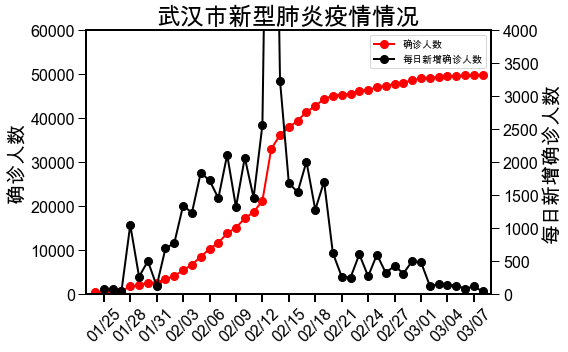

In [5]:

WuhanDf = pd.read_sql_query("""select updateTime, confirmedCount from City_Data where cityName='武汉';""", conn)
WuhanDf['date'] = pd.to_datetime(WuhanDf['updateTime'].apply(int)/1000, unit='s')
WuhanDf = WuhanDf.set_index('date')
dailyMeanWuhan = WuhanDf.resample('D').mean().round()

fig, ax1 = plt.subplots(figsize=(8, 5))

s1, = ax1.plot(
    dailyMeanWuhan.index,
    dailyMeanWuhan['confirmedCount'],
    color='r', marker='o')
ax1.set_ylabel(u'确诊人数')
ax1.set_ylim([0, 60000])

ax2 = ax1.twinx()
s2, = ax2.plot(
    dailyMeanWuhan.index[1:], np.diff(dailyMeanWuhan['confirmedCount']),
    color='k', marker='o')
ax2.set_ylabel(u'每日新增确诊人数')
ax2.set_ylim([0, 4000])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xlim(
    [dt.datetime(2020, 1, 23),
        max(dailyMeanWuhan.index) + dt.timedelta(days=1)])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.title('武汉市新型肺炎疫情情况', fontsize=24)
plt.legend(
    (s1, s2),
    (u'确诊人数', u'每日新增确诊人数'))

## 鄂州市疫情情况

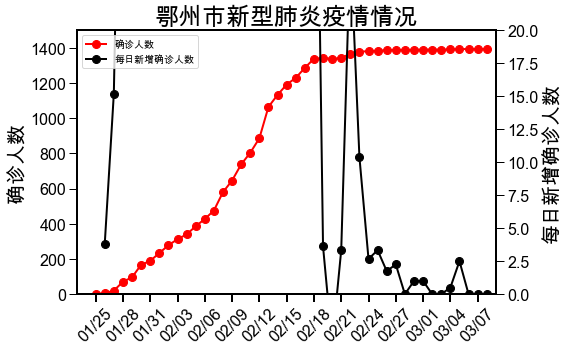

In [6]:
EzhouDf = pd.read_sql_query("""select updateTime, confirmedCount from City_Data where cityName='鄂州';""", conn)
EzhouDf['date'] = pd.to_datetime(EzhouDf['updateTime'].apply(int)/1000, unit='s')
EzhouDf = EzhouDf.set_index('date')
dailyMeanEzhou = EzhouDf.resample('D').mean()

fig, ax1 = plt.subplots(figsize=(8, 5))

s1, = ax1.plot(
    dailyMeanEzhou.index,
    dailyMeanEzhou['confirmedCount'],
    color='r', marker='o')
ax1.set_ylim([0, 1500])
ax1.set_ylabel(u'确诊人数')
ax2 = ax1.twinx()
s2, = ax2.plot(
    dailyMeanEzhou.index[1:], np.diff(dailyMeanEzhou['confirmedCount']),
    color='k', marker='o')
ax2.set_ylabel(u'每日新增确诊人数')
ax2.set_ylim([0, 20])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xlim(
    [dt.datetime(2020, 1, 23),
        max(dailyMeanEzhou.index) + dt.timedelta(days=1)])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.title('鄂州市新型肺炎疫情情况', fontsize=24)
plt.legend(
    (s1, s2),
    (u'确诊人数', u'每日新增确诊人数'),
    loc='upper left')